# TP3

Encontrar el logotipo de la gaseosa dentro de las imagenes provistas en Material_TPs/TP3/images a partir del template Material_TPs/TP3/template

In [1]:
# Importing necessary libraries
import cv2 as cv
import numpy as np
import math
import matplotlib.pyplot as plt
from imutils.object_detection import non_max_suppression

In [2]:
# Function definitions
def load_and_convert_image(path, color_mode=cv.COLOR_BGR2RGB):
    image = cv.imread(path)
    return cv.cvtColor(image, color_mode)

def apply_edge_detection(image, threshold1=50, threshold2=200):
    return cv.Canny(image, threshold1, threshold2)

def resize_image(image, scale):
    return cv.resize(image, None, fx=scale, fy=scale)

def find_optimal_match(image, template, method):
    match_result = cv.matchTemplate(image, template, method)
    _, max_val, _, max_loc = cv.minMaxLoc(match_result)
    return max_val, max_loc, match_result

def draw_rectangle(image, top_left, bottom_right, color=(0,255,0), thickness=3):
    output_image = image.copy()
    cv.rectangle(output_image, top_left, bottom_right, color=color, thickness=thickness)
    return output_image

def display_images(images, titles):
    fig = plt.figure(figsize=(18,18))
    for i, (image, title) in enumerate(zip(images, titles)):
        fig.add_subplot(len(images), 1, i+1)
        plt.imshow(image)
        plt.title(title)
    plt.tight_layout()
    plt.show()

def load_images(image_paths):
    rgb_images = [load_and_convert_image(path) for path in image_paths]
    gray_images = [load_and_convert_image(path, cv.COLOR_BGR2GRAY) for path in image_paths]
    return rgb_images, gray_images

In [3]:
# Load images and templates
image_paths = [
    './images/coca_logo_1.png', 
    './images/coca_logo_2.png', 
    './images/COCA-COLA-LOGO.jpg',
    './images/coca_multi.png', 
    './images/coca_retro_1.png', 
    './images/coca_retro_2.png', 
    './images/logo_1.png'
]

image_template_path = './template/pattern.png'

## 1. (4 puntos) Obtener una deteccion del logo en cada imagen sin falsos positivos.

In [4]:
# Detect a logo in an image using template matching.
def detect_logo(gray_image, rgb_image, template, method, current_image, total_images):
    print(f"Processing image {current_image} of {total_images}")
    template_width, template_height = template.shape[::-1]
    scales = np.linspace(0.1, 4.0, 20)[::-1] 
    optimal_value, optimal_match = 0, 0

    for scale in scales:
        resized_image = resize_image(gray_image, scale)
        edge_detected_image = apply_edge_detection(resized_image)

        if resized_image.shape[1] < template_width or resized_image.shape[0] < template_height:
            break

        max_val, max_loc, match_result = find_optimal_match(edge_detected_image, template, method)

        if max_val > optimal_value:
            optimal_value = max_val
            optimal_match = (max_loc, scale)

    top_left, optimal_scale = optimal_match
    top_left_scaled = (int(top_left[0] / optimal_scale), int(top_left[1] / optimal_scale))
    bottom_right = (int((top_left[0] + template_width)/ optimal_scale), int((top_left[1] + template_height) / optimal_scale))

    output_image = draw_rectangle(rgb_image, top_left_scaled, bottom_right)

    return output_image, optimal_scale, optimal_value, match_result

In [5]:
# Prepare the images and the template for logo detection.
rgb_images, gray_images = load_images(image_paths)
template = cv.imread(image_template_path,0)
edge_detected_template = apply_edge_detection(template)
method = eval('cv.TM_CCOEFF_NORMED')

In [6]:
# Apply the logo detection to all images.
total_images = len(rgb_images)
results = [detect_logo(gray_image, rgb_image, edge_detected_template, method, i+1, total_images) for i, (gray_image, rgb_image) in enumerate(zip(gray_images, rgb_images))]

detected_images = [result[0] for result in results]
optimal_scales = [result[1] for result in results]
max_vals = [result[2] for result in results]

Processing image 1 of 7
Processing image 2 of 7
Processing image 3 of 7
Processing image 4 of 7
Processing image 5 of 7
Processing image 6 of 7
Processing image 7 of 7


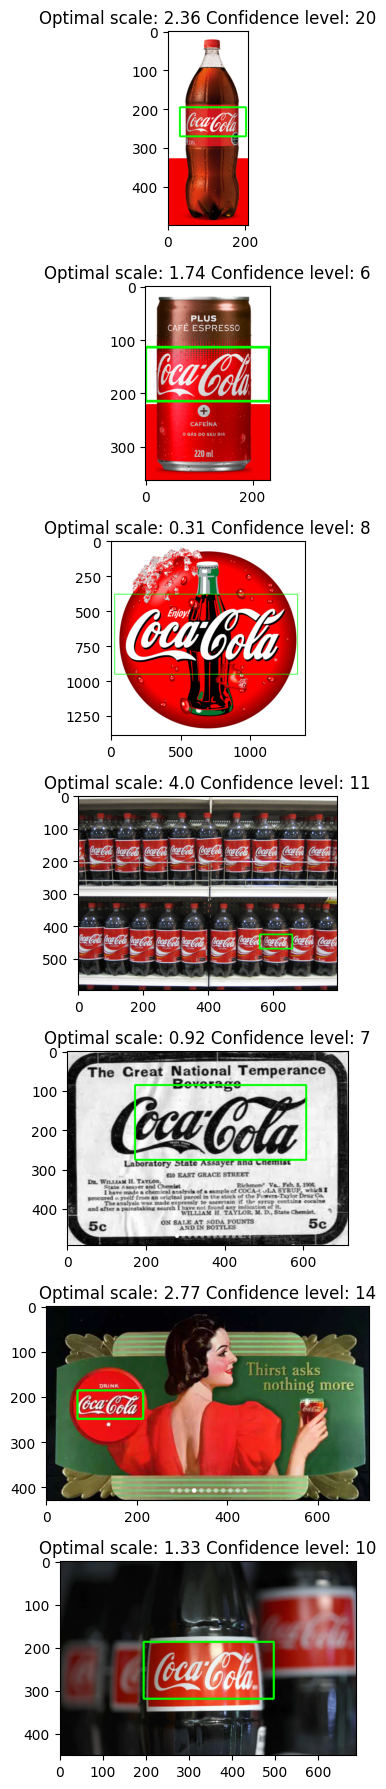

In [7]:
# Display the results.
titles = [f"Optimal scale: {round(optimal_scales[i], 2)} Confidence level: {int(max_vals[i] * 100)}" for i in range(len(rgb_images))]
display_images(detected_images, titles)

## 2. (4 puntos) Plantear y validar un algoritmo para múltiples detecciones en la imagen coca_multi.png con el mismo témplate del ítem 1.

In [8]:
# Functions definition.
def match_template(image, template, method):
    return cv.matchTemplate(image, template, method)

def get_best_match(scales, gray_image, template, method):
    best_match_value = 0
    template_width, template_height = template.shape[::-1]

    for scale in scales:
        resized_image = resize_image(gray_image, scale)
        resized_width, resized_height = resized_image.shape[::-1]

        if resized_width < template_width or resized_height < template_height:
            break

        edge_image = apply_edge_detection(resized_image)
        match_result = match_template(edge_image, template, method)
        _, max_val, _, _ = cv.minMaxLoc(match_result)

        if max_val > best_match_value:
            best_match_value = max_val
            best_scale = scale
            best_match_result = match_result

    return best_match_value, best_scale, best_match_result

def get_detection_boxes(locations, best_scale, template_width, template_height):
    detection_boxes = []
    for position in zip(*locations[::-1]):
        start_x = int(position[0] / best_scale)
        start_y = int(position[1] / best_scale)
        end_x = int((position[0] + template_width) / best_scale)
        end_y = int((position[1] + template_height) / best_scale)
        detection_boxes.append((start_x, start_y, end_x, end_y))
    return detection_boxes

def draw_boxes(image, boxes):
    for (startX, startY, endX, endY) in boxes:
        cv.rectangle(image, (startX, startY), (endX, endY), color=(0, 255, 0), thickness=2)
    return image


In [17]:
# Detects multiple logos in an image using template matching, non-maximum suppression, and draws bounding boxes around detected logos.
def detect_multiple_logos(scales, gray_image, rgb_image, template, method, current_image, total_images, threshold=0.06):
    print(f"Processing image {current_image} of {total_images}")
    template_width, template_height = template.shape[::-1]

    best_match_value, best_scale, best_match_result = get_best_match(scales, gray_image, template, method)

    locations = np.where(best_match_result >= threshold)
    detection_boxes = get_detection_boxes(locations, best_scale, template_width, template_height)

    selected_boxes = non_max_suppression(np.array(detection_boxes))

    output_image = draw_boxes(rgb_image.copy(), selected_boxes)

    return output_image, best_match_value, best_match_result

In [23]:
# Prepare the image for logo detection.
multi_image_path = './images/coca_multi.png'
multi_image_rgb = load_and_convert_image(multi_image_path)
multi_image_gray = load_and_convert_image(multi_image_path, cv.COLOR_BGR2GRAY)

In [27]:
# Detect multiple logos
total_images = len(multi_image_rgb)
scales = np.linspace(0.1, 4.0, 20)[::-1]
detected_image, match_value, match_result = detect_multiple_logos(scales, multi_image_gray, multi_image_rgb, edge_detected_template, method, 1, 1)

Processing image 1 of 1


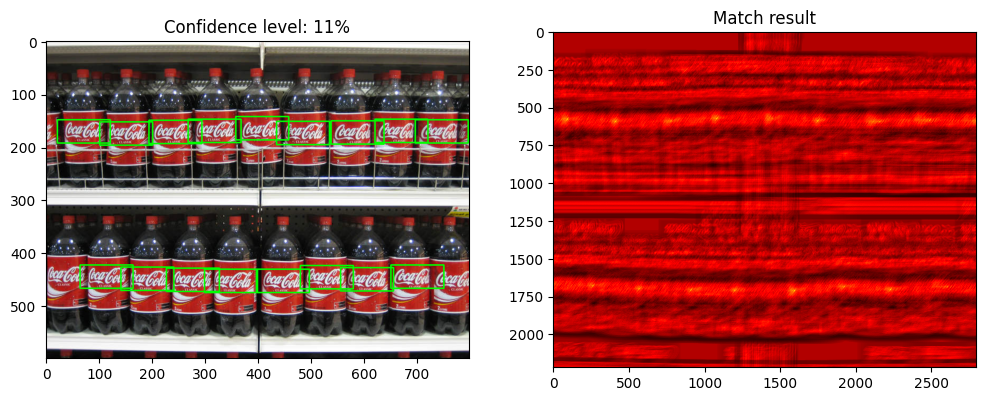

In [28]:
# Display images
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(detected_image)
plt.title(f'Confidence level: {int(match_value * 100)}%')

# Display match result
plt.subplot(1, 2, 2)
plt.imshow(match_result, cmap='hot')
plt.title('Match result')
plt.show()

## 3. (2 puntos) Generalizar el algoritmo del item 2 para todas las imágenes.

In [13]:
# Prepare the images and the template for logo detection.
rgb_images, gray_images = load_images(image_paths)
template = cv.imread(image_template_path,0)
edge_detected_template = apply_edge_detection(template)
method = eval('cv.TM_CCOEFF_NORMED')

In [20]:
# Detect multiple logos in all images
scales = np.linspace(0.1, 4.0, 55)[::-1]
total_images = len(gray_images)
results = [detect_multiple_logos(scales, gray_image, rgb_image, edge_detected_template, method, i+1, total_images, threshold=0.07) for i, (gray_image, rgb_image) in enumerate(zip(gray_images, rgb_images))]
detected_images = [result[0] for result in results]
match_values = [result[1] for result in results]

Processing image 1 of 7
Processing image 2 of 7
Processing image 3 of 7
Processing image 4 of 7
Processing image 5 of 7
Processing image 6 of 7
Processing image 7 of 7


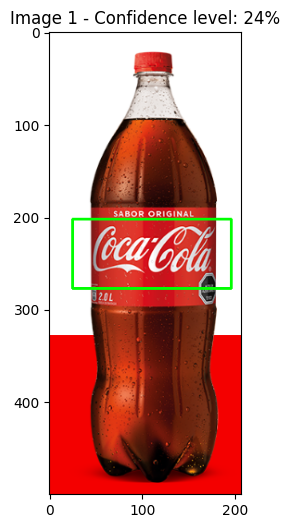

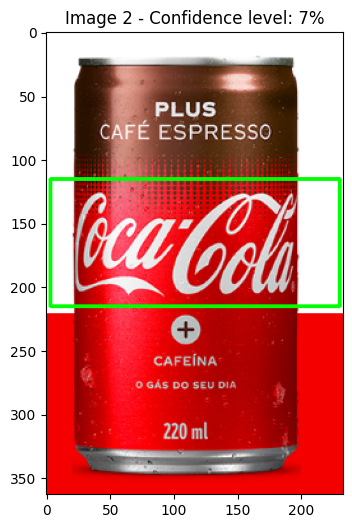

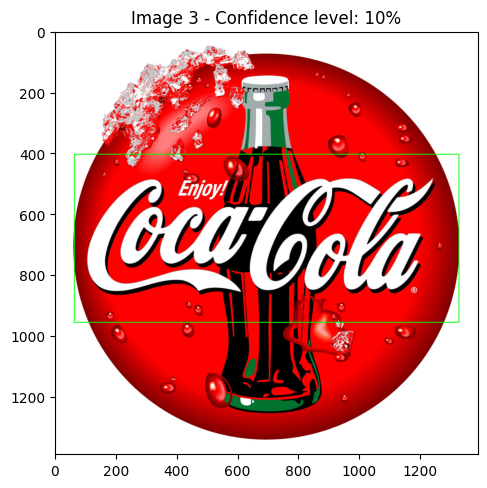

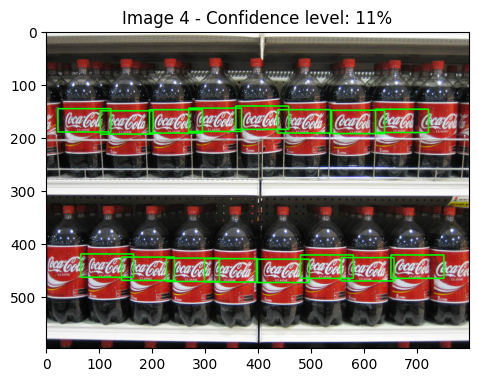

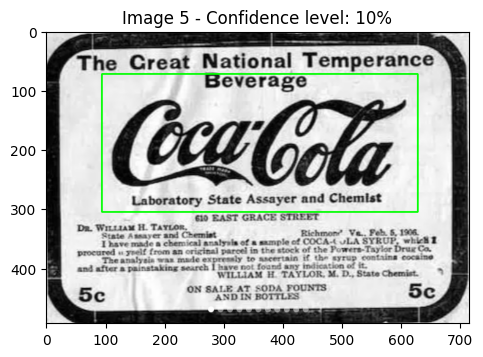

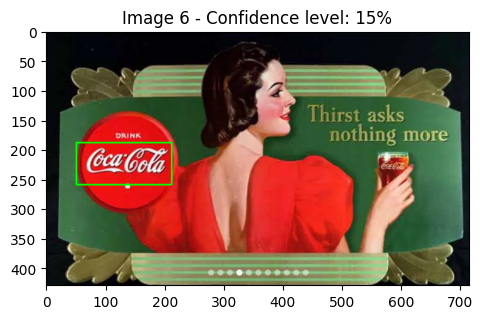

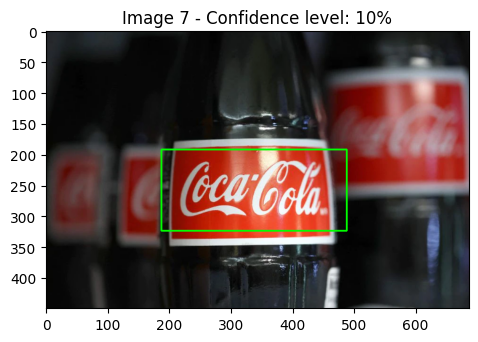

In [21]:
# Display the results.
for i, image in enumerate(detected_images):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title(f'Image {i+1} - Confidence level: {int(match_values[i] * 100)}%')
    plt.show()